# Convolutional autoencoder for image denoising


## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

11490434/11490434 [==============================] - 1s 0us/step


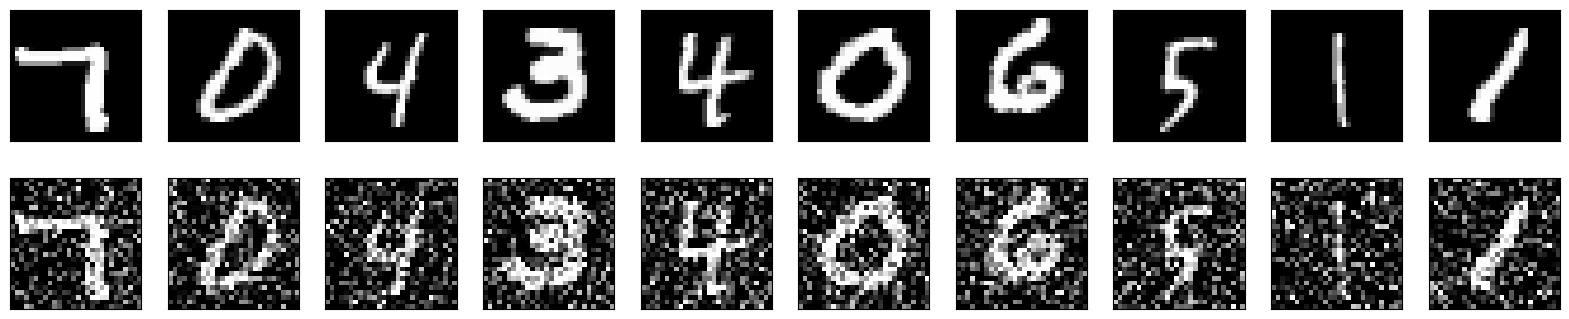

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, train_label), (test_data, test_label) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

As you do not know convolutional neural network yet, do not worry about the full details of the following codes. Just note that you have an encoder and a decoder of autoencoders that are convolutional neural networks. The ``intermediate'' variable is where the features are stored. Later, you need to use this variable and pass to the logistic regression classifier for classification.

You will be introduced to convolutional neural network in Week 11.

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
intermediate = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(intermediate)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248  

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/15
469/469 [==============================] - 10s 10ms/step - loss: 0.1295 - val_loss: 0.0727
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0711 - val_loss: 0.0692
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0689 - val_loss: 0.0678
Epoch 4/15
469/469 [==============================] - 7s 14ms/step - loss: 0.0677 - val_loss: 0.0669
Epoch 5/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0670 - val_loss: 0.0662
Epoch 6/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0664 - val_loss: 0.0657
Epoch 7/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0660 - val_loss: 0.0654
Epoch 8/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0657 - val_loss: 0.0650
Epoch 9/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 10/15
469/469 [==============================] - 4s 7ms/step - loss: 0.0651 - val_loss: 0.

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 [==============================] - 1s 2ms/step


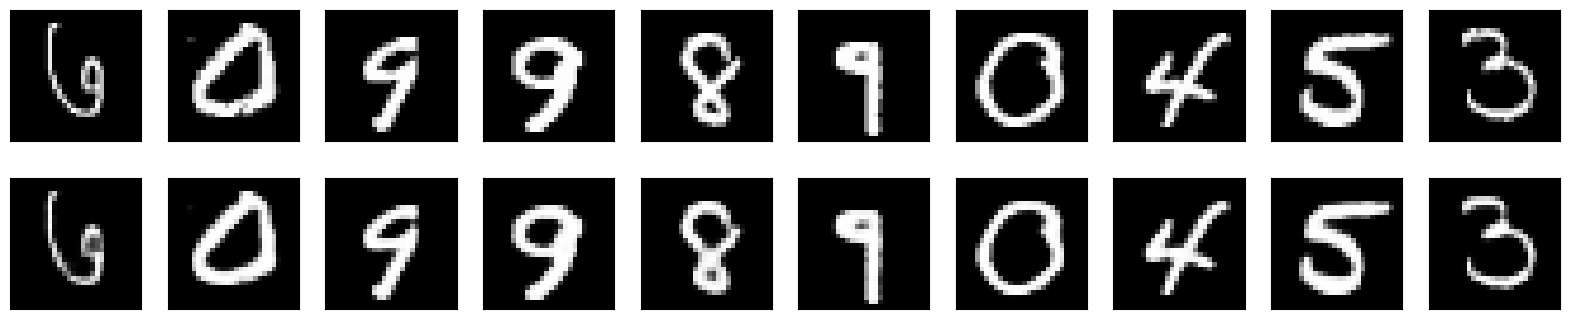

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/15
469/469 [==============================] - 4s 9ms/step - loss: 0.1003 - val_loss: 0.0930
Epoch 2/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0926 - val_loss: 0.0908
Epoch 3/15
469/469 [==============================] - 5s 10ms/step - loss: 0.0910 - val_loss: 0.0897
Epoch 4/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0899 - val_loss: 0.0887
Epoch 5/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0892 - val_loss: 0.0881
Epoch 6/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0887 - val_loss: 0.0876
Epoch 7/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0883 - val_loss: 0.0874
Epoch 8/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0879 - val_loss: 0.0874
Epoch 9/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0876 - val_loss: 0.0869
Epoch 10/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0873 - val_loss: 

The following piece of code is an example of how intermediate layers in Keras can be used to extract representations.

In [7]:
encoder = Model(inputs=input, outputs=intermediate)
encoder.save('encoder.h5')
X_train_encode = encoder.predict(noisy_train_data)
X_test_encode = encoder.predict(noisy_test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 0s 1ms/step


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 [==============================] - 1s 2ms/step


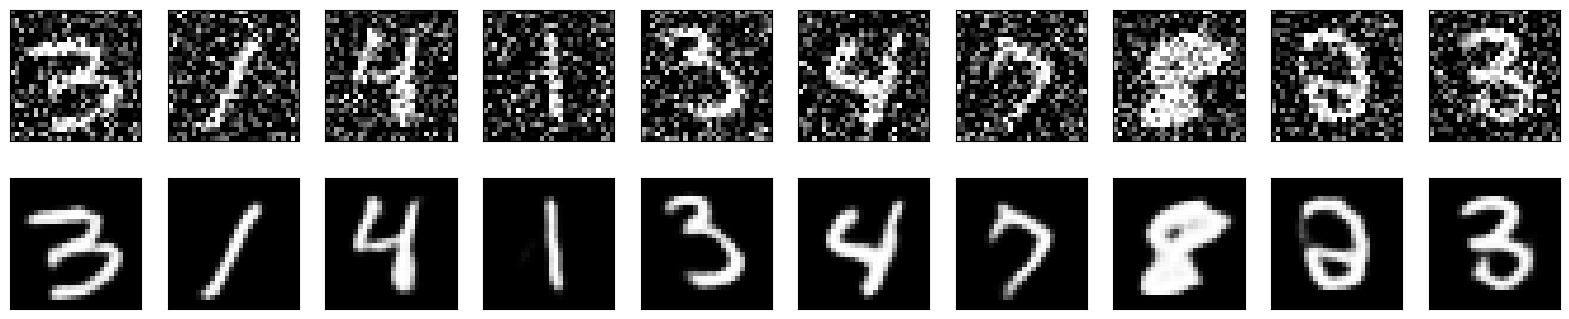

In [8]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

Train Logistic Regression on the features.


**Name: Sharryl Seto**

**ID: 1005523**

H1: Fit the classifier on the original images. Train Input - noisy images, Test Input - Noisy images.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(max_iter=30)
noisy_train_data_new = noisy_train_data.reshape(noisy_train_data.shape[0],noisy_train_data.shape[1]*noisy_train_data.shape[2]*noisy_train_data.shape[3])
clf.fit(noisy_train_data_new, train_label)
noisy_test_data_new = noisy_test_data.reshape(noisy_test_data.shape[0],noisy_test_data.shape[1]*noisy_test_data.shape[2]*noisy_test_data.shape[3])
predictions = clf.predict(noisy_test_data_new)
print(accuracy_score(test_label,predictions))

0.8794


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Q1: Fit the classifier on the original images. Train Input - clean images, Test Input - Noisy images.

In [13]:
clf = LogisticRegression(max_iter=30)
clean_train_data = train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
clf.fit(clean_train_data, train_label)
noisy_test_data_new = noisy_test_data.reshape(noisy_test_data.shape[0],noisy_test_data.shape[1]*noisy_test_data.shape[2]*noisy_test_data.shape[3])
predictions = clf.predict(noisy_test_data_new)
print(accuracy_score(test_label,predictions))

0.6754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Q2: Fit the classifier on the features extracted by the autoencoder. Train Input to autoencoder - Noisy images. Test Input to autoencoder - Noisy images.

Note that the logistic regression classifier too must take argument of noisy train and test images.

Hint: Call encoder.predict() and pass the desired argument.

In [14]:
X_train_encode = autoencoder.predict(noisy_train_data)
X_test_encode = autoencoder.predict(noisy_test_data)

313/313 [==============================] - 1s 2ms/step


In [15]:
clf = LogisticRegression(max_iter=30)
noisy_train_data_new = X_train_encode.reshape(X_train_encode.shape[0],X_train_encode.shape[1]*X_train_encode.shape[2]*X_train_encode.shape[3])
clf.fit(noisy_train_data_new, train_label)
noisy_test_data_new = X_test_encode.reshape(X_test_encode.shape[0],X_test_encode.shape[1]*X_test_encode.shape[2]*X_test_encode.shape[3])
predictions = clf.predict(noisy_test_data_new)
print(accuracy_score(test_label,predictions))

0.9118


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Q3: Fit the classifier on the features extracted by the autoencder. Train Input to autoencoder - Clean images. Test Input to autoencoder - Noisy images.

Note that the logistic regression classifier too must take argument of clean train and noisy test images.

Hint: Call encoder.predict() and pass the desired argument.

In [16]:
X_train_encode = autoencoder.predict(train_data)
X_test_encode = autoencoder.predict(noisy_test_data)

313/313 [==============================] - 1s 3ms/step


In [17]:
clf = LogisticRegression(max_iter=30)
clean_train_data_new = X_train_encode.reshape(X_train_encode.shape[0],X_train_encode.shape[1]*X_train_encode.shape[2]*X_train_encode.shape[3])
clf.fit(clean_train_data_new, train_label)
noisy_test_data_new = X_test_encode.reshape(X_test_encode.shape[0],X_test_encode.shape[1]*X_test_encode.shape[2]*X_test_encode.shape[3])
predictions = clf.predict(noisy_test_data_new)
print(accuracy_score(test_label,predictions))

0.9105


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Q4: Compare the performance between the results in H1, Q1, Q2, Q3 and explain the reason for performance differences in these experiments.

|No.| Train | Test | Accuracy |
|---|:-----:|:----:|----------|
|H1 | noisy | noisy| 0.8794 |
|Q1 | clean | noisy| 0.6754 |
|Q2 | noisy, autoencoder | noisy, autoencoder| 0.9118 |
|H1 | clean, autoencoder | noisy, autoencoder| 0.9105 |


H1 has a relatively high accuracy of 0.8794, as it is a simple training on noisy and test on noisy.

Q1 has a lower accuracy of 0.6754, as we train with clean and test on noisy. It will not be able to predict as well due to the noise on the test set.

For Q2 and Q3, the features are extracted from the autoencoder. This means that the autoencoder is able to denoise the images.

Q2 has a higher accuracy than H1 although they both had the same noisy training and test input. The autoencoder was able to denoise the images to create a cleaner training input to the classifier. The classifier is then able to train and perform better on the test with cleaner test input as well.

Q3 has a clean training input and noisy test input. Q3 performed as well as Q2, as it is able to denoise the test input and perform well after training on clean images.